**Learner Name: Damian Najera**

# Supervised Learning Classification Project: AllLife Bank Personal Loan Campaign

## Problem Statement

### Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [1197]:
%load_ext nb_black

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)


# To build model for prediction

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV

# To get diferent metric scores

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Loading the dataset

In [1198]:
loan_df = pd.read_csv("Loan_Modeling.csv")

<IPython.core.display.Javascript object>

## Data Overview

* Observations
* Sanity checks

### View the first and last 5 rows of the dataset.

In [1199]:
loan_df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


<IPython.core.display.Javascript object>

In [1200]:
loan_df.tail()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0.8,1,0,0,0,0,1,1


<IPython.core.display.Javascript object>

### Understand the shape of the dataset.

In [1201]:
loan_df.shape

(5000, 14)

<IPython.core.display.Javascript object>

### Check the data types of the columns for the dataset.

In [1202]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


<IPython.core.display.Javascript object>

In [1203]:
loan_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93169.257000,1759.455086,90005.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal_Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


<IPython.core.display.Javascript object>

In [1204]:
# checking for unique values in ID column
loan_df["ID"].nunique()

5000

<IPython.core.display.Javascript object>

* Since all the values in ID column are unique we can drop it

In [1205]:
loan_df.drop(["ID"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

### Check for missing values

In [1206]:
loan_df.isnull().sum()

Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

<IPython.core.display.Javascript object>

* There are no missing values in the dataset

#### Observations:
- Upon looking at the head and tail of the dataset, it appears our data was indeed loaded correctly
- Looking at the shape with `loan_df.shape`, we can see we the dataset has 5000 rows and 14 columns
- By using `loan_df.info()`, we can see the data has 2 different datatypes:
    - 1 columns of type float64, which is a 64-bit floating point number
        - CCAvg
    - 13 columns of type int64, which is a 64-bit integer
        - ID, Age, Experience, Income, ZIPCode, Family, Education, Mortgage, Personal_Loan, Securities_Account, CDAccount, Online, CreditCard
- Looking at the statistical summary with `loan_df.describe().T` reveals some interesting things to note, such as Experience having a min value of -3. 
- Each ID is unique, there are no duplicate entries and there are no missing values in the dataset



## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

### Checking for Anomalous Values

In [1207]:
# Map the values to 1: Undergrad; 2: Graduate 3: Advanced/Professional
loan_df["Education"].replace(1, "Undergraduate", inplace=True)
loan_df["Education"].replace(2, "Graduate", inplace=True)
loan_df["Education"].replace(3, "Advanced/Professional", inplace=True)

<IPython.core.display.Javascript object>

* Treating the negative values of Experience: We assume that these negative signs here are data input errors, so we will replace them with positive signs

In [1208]:
# checking if experience <0
loan_df[loan_df["Experience"] < 0]["Experience"].unique()

array([-1, -2, -3], dtype=int64)

<IPython.core.display.Javascript object>

In [1209]:
# Correcting the experience values
loan_df["Experience"].replace(-1, 1, inplace=True)
loan_df["Experience"].replace(-2, 2, inplace=True)
loan_df["Experience"].replace(-3, 3, inplace=True)

<IPython.core.display.Javascript object>

### Feature Engineering

In [1210]:
# checking the number of uniques in the zip code
loan_df["ZIPCode"].nunique()

467

<IPython.core.display.Javascript object>

In [1211]:
loan_df["ZIPCode"] = loan_df["ZIPCode"].astype(str)
print(
    "Number of unique values if we take first two digits of ZIPCode: ",
    loan_df["ZIPCode"].str[0:2].nunique(),
)
loan_df["ZIPCode"] = loan_df["ZIPCode"].str[0:2]

loan_df["ZIPCode"] = loan_df["ZIPCode"].astype("category")

Number of unique values if we take first two digits of ZIPCode:  7


<IPython.core.display.Javascript object>

In [1212]:
## Converting the data type of categorical features to 'category'
cat_cols = [
    "Education",
    "Personal_Loan",
    "Securities_Account",
    "CD_Account",
    "Online",
    "CreditCard",
    "ZIPCode",
]
loan_df[cat_cols] = loan_df[cat_cols].astype("category")

<IPython.core.display.Javascript object>

## Exploratory Data Analysis.

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Univariate Analysis

In [1213]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

In [1214]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

#### Age

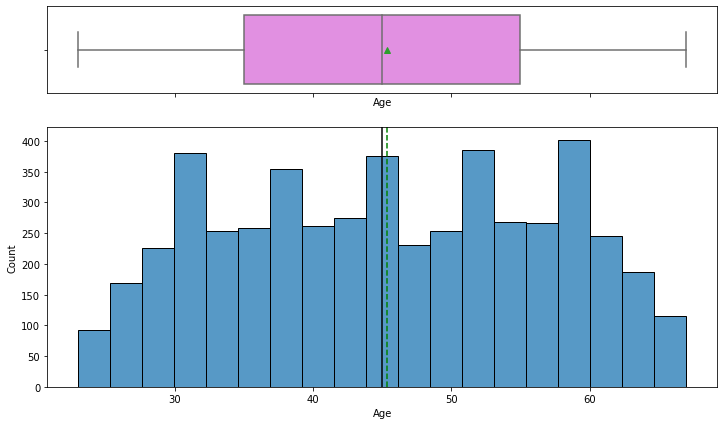

<IPython.core.display.Javascript object>

In [1215]:
histogram_boxplot(loan_df, "Age")

##### Observations
- Minimum Age: 23
- Maximum Age: 67
- Average Age: 45
- There are no outliers in the data

#### Experience

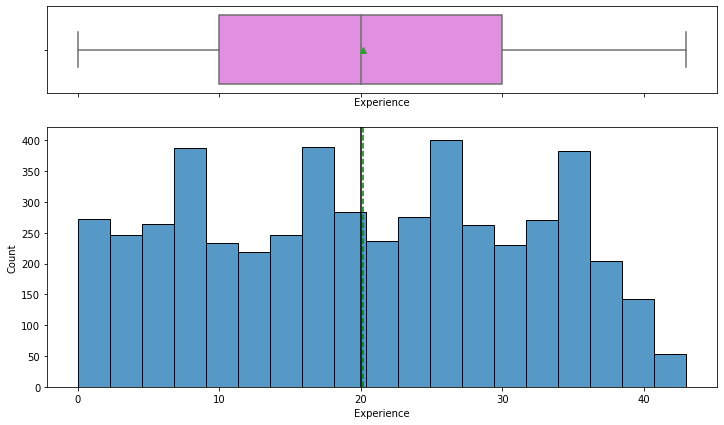

<IPython.core.display.Javascript object>

In [1216]:
histogram_boxplot(loan_df, "Experience") 

##### Observations:
- Minimum Years of Experience: 0 years
- Maximum Years of Experience: 43 years
- Average Years of Experience: About 20 years
- There are no outliers in the data

#### Income

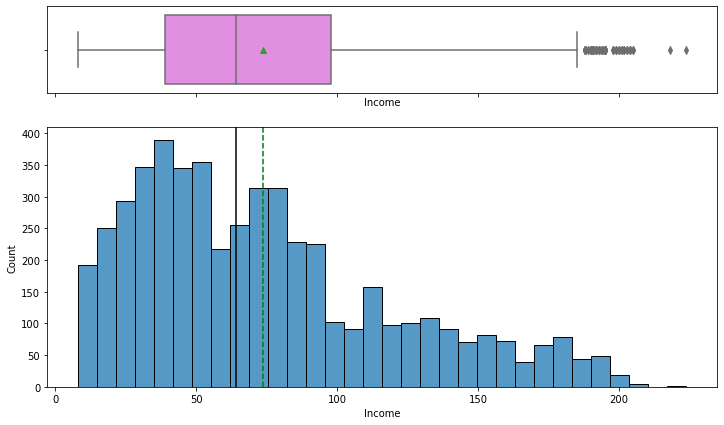

<IPython.core.display.Javascript object>

In [1217]:
histogram_boxplot(loan_df, "Income") 

##### Observations:
- Minimum Income: $8k
- Maximum Income: $224k
- Average Income: $64k 
- Dataset is right skewed
- There are outliers in the data, however it appears they are consistent with the rest of the data so no action is required to treat these outliers

#### CCAvg

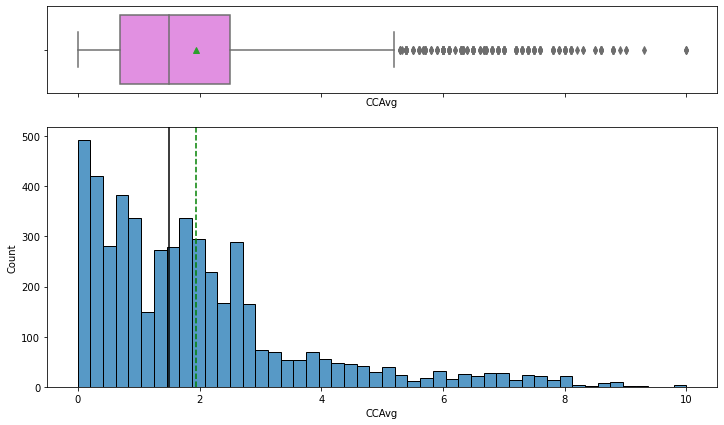

<IPython.core.display.Javascript object>

In [1218]:
histogram_boxplot(loan_df, "CCAvg") 

##### Observations:
- Minimum: $0k 
- Maximum: $10k 
- Average: About $1.9k
- Dataset is skewed to the right
- There are outliers in the data, however it appears they are consistent with the rest of the data so no action is required to treat these outliers

#### Mortgage

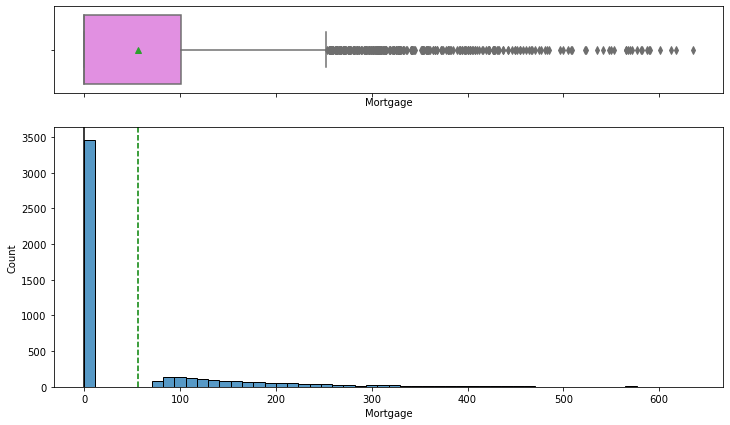

<IPython.core.display.Javascript object>

In [1219]:
histogram_boxplot(loan_df, "Mortgage") 

Let's get a better view of mortgage > $0k:

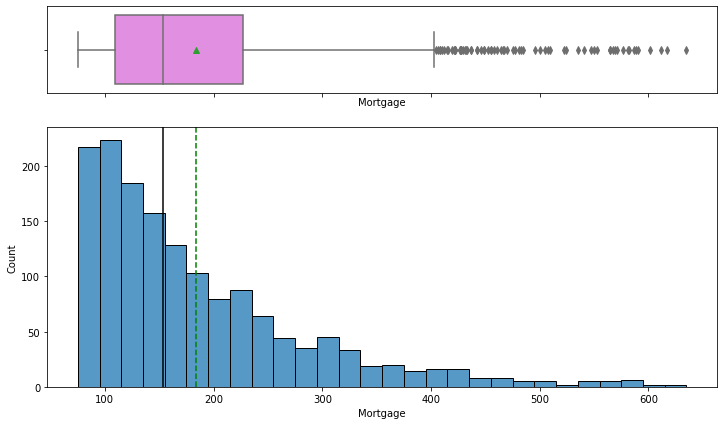

<IPython.core.display.Javascript object>

In [1220]:
mortgage_gt_zero = loan_df[loan_df['Mortgage'] > 0]
histogram_boxplot(mortgage_gt_zero, "Mortgage")

##### Observations
- Minimum: $0k (or about $99k when not considering those with $0k mortgage)
- Maximum: $635k
- Average: About $56.5k
- Dataset is skewed to the right
- There are outliers in the data, however it appears they are consistent with the rest of the data so no action is required to treat these outliers

#### Family 

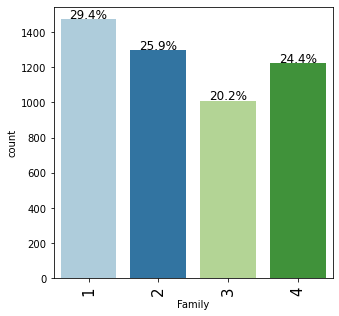

<IPython.core.display.Javascript object>

In [1221]:
labeled_barplot(loan_df, "Family", perc=True) 

##### Observations:
The majority of families are of size 1 (29.4%), followed by families of size 2 (25.9%). Third is families of size 4 (24.4%), and the minority is families of size 3 (20.2%).

#### Education

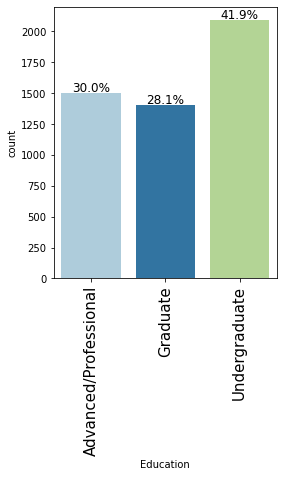

<IPython.core.display.Javascript object>

In [1222]:
labeled_barplot(loan_df, "Education", perc=True) 

##### Observations:
- 41.9% of customers: Undergraduate 
- 30.0% of customers: Advanced/Professional
- 28.1% of customers: Graduate

#### Securities_Account

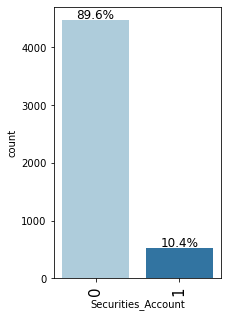

<IPython.core.display.Javascript object>

In [1223]:
labeled_barplot(loan_df, "Securities_Account", perc=True) 

##### Observations:
89.6% of customers do not have securities accounts with the bank, and 10.4% of customers do have securities accounts with the bank.

#### CD_Account

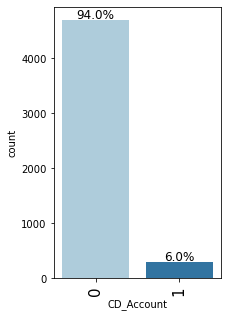

<IPython.core.display.Javascript object>

In [1224]:
labeled_barplot(loan_df, "CD_Account", perc=True) 

##### Observations:
94.0% of customers do not have a CD account with the bank, while 6% of customers do have a CD account with the bank. 

#### Online

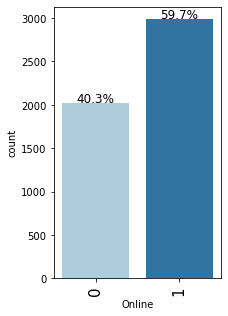

<IPython.core.display.Javascript object>

In [1225]:
labeled_barplot(loan_df, "Online", perc=True) 

##### Observations:
59.7% of customers use internet banking facilities, while 40.3% of customers do not. 

#### CreditCard

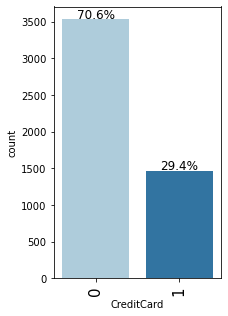

<IPython.core.display.Javascript object>

In [1226]:
labeled_barplot(loan_df, "CreditCard", perc=True) 

##### Observations:
70.6% of customers do not use a credit card issued by another bank, while 29.4% of customers do use a credit issued by another bank. 

#### ZIPCode

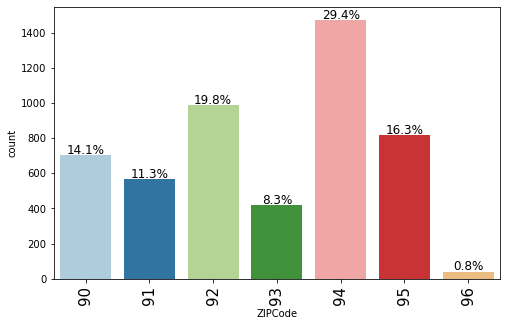

<IPython.core.display.Javascript object>

In [1227]:
labeled_barplot(loan_df, "ZIPCode", perc=True) 

##### Observations:
- 29.4% of customers reside in the zip code beginning in 94
- 19.8% of customers reside in the zip code beginning in 92
- 16.3% of customers reside in the zip code beginning in 95
- 14.1% of customers reside in the zip code beginning in 90
- 11.3% of customers reside in the zip code beginning in 91
- 8.3% of customers reside in the zip code beginning in 93
- 0.8% of customers reside in the zip code beginning in 96

### Bivariate Analysis

In [1228]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

<IPython.core.display.Javascript object>

In [1229]:
### function to plot distributions wrt target

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

#### Correlation check

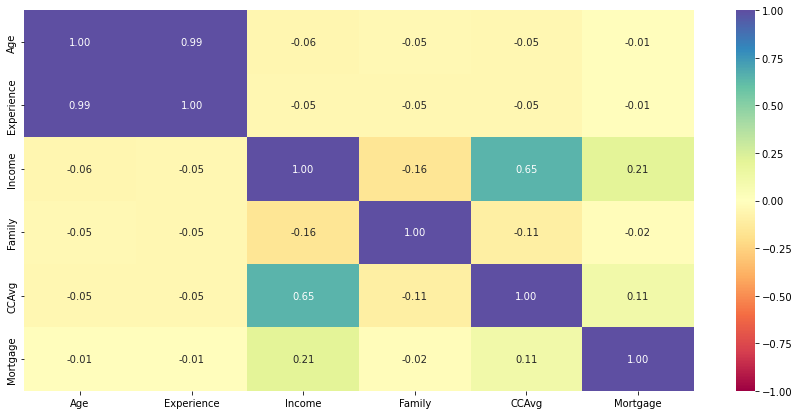

<IPython.core.display.Javascript object>

In [1230]:
plt.figure(figsize=(15, 7))
sns.heatmap(loan_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral") 
plt.show()

#### Age vs Personal_Loan

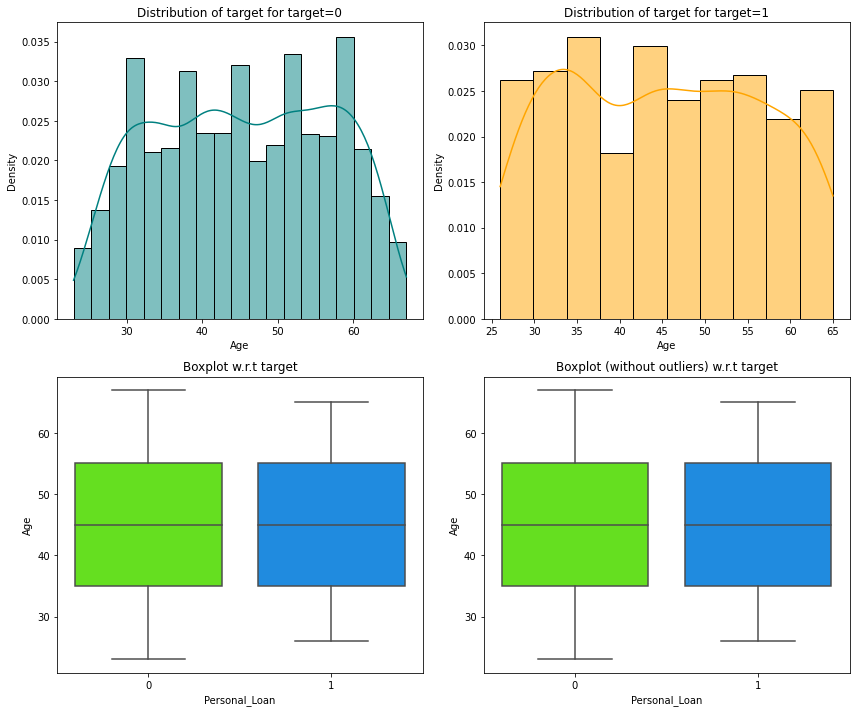

<IPython.core.display.Javascript object>

In [1231]:
distribution_plot_wrt_target(loan_df, "Age", "Personal_Loan")

##### Observations:
It appears Age does not have a relationship with Personal_Loan

#### Experience vs Personal_Loan

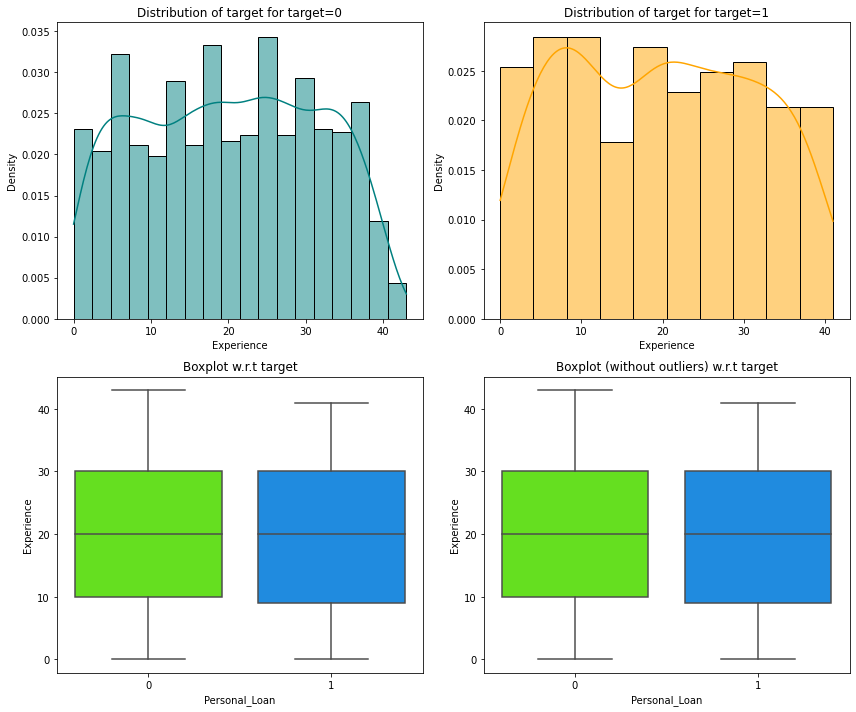

<IPython.core.display.Javascript object>

In [1232]:
distribution_plot_wrt_target(loan_df, "Experience", "Personal_Loan")

##### Observations:
It appears Experience does not have a relationship with Personal_Loan

#### Income vs Personal_Loan

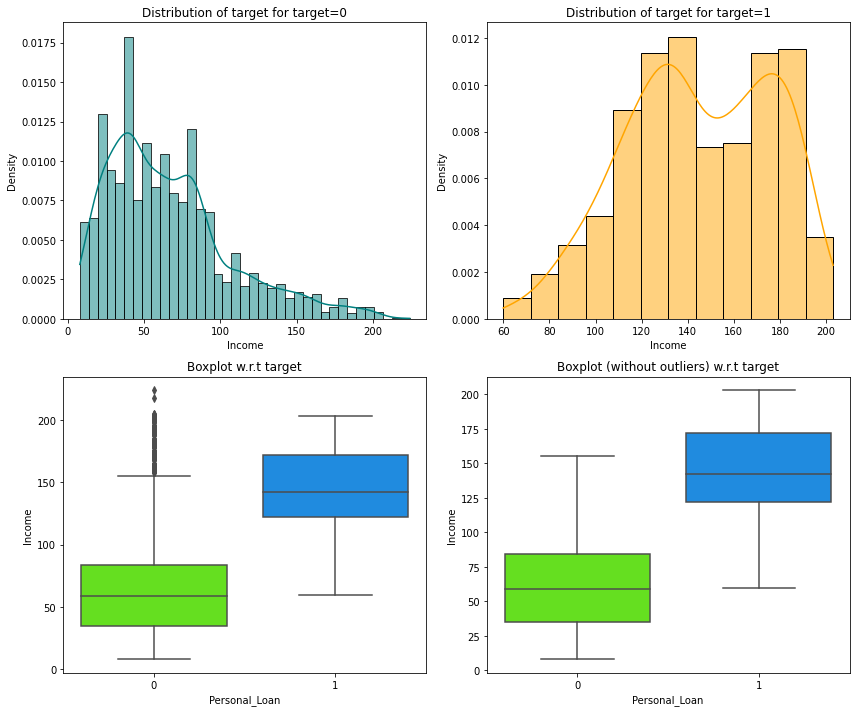

<IPython.core.display.Javascript object>

In [1233]:
distribution_plot_wrt_target(loan_df, "Income", "Personal_Loan")

##### Observations:
- The mean income for customers who did not accept a personal loan is about $65k
- The mean income for customers who did accept a personal loan is about $145k
- Based on the graphs, it appears there is a relationship between Income and Personal_Loan. We can observe that the higher the income, the more likely the customer will accept a personal loan. 

#### Personal_Loan vs ZIPCode

ZIPCode         90   91   92   93    94   95  96   All
Personal_Loan                                         
All            703  565  988  417  1472  815  40  5000
0              636  510  894  374  1334  735  37  4520
1               67   55   94   43   138   80   3   480
------------------------------------------------------------------------------------------------------------------------


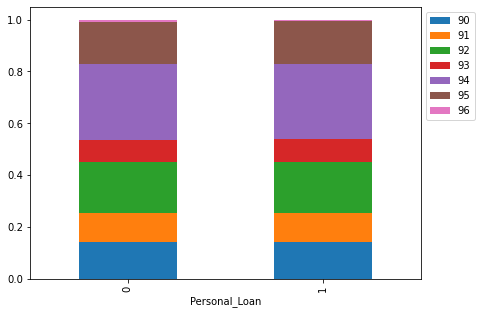

<IPython.core.display.Javascript object>

In [1234]:
stacked_barplot(loan_df, "Personal_Loan", "ZIPCode")  

##### Observations:
- It appears that there are some zip codes that are more likely to accept personal loans, specifically those whose zip code leads with a 94, whereas those in zip code leading in 93 appear less likely to accept a personal loan. 

#### Family vs Personal_Loan

Personal_Loan     0    1   All
Family                        
All            4520  480  5000
4              1088  134  1222
3               877  133  1010
1              1365  107  1472
2              1190  106  1296
------------------------------------------------------------------------------------------------------------------------


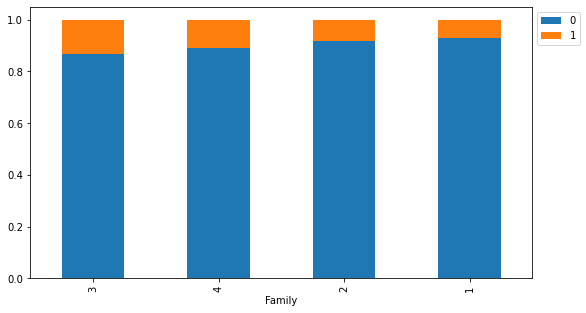

<IPython.core.display.Javascript object>

In [1235]:
stacked_barplot(loan_df, "Family", "Personal_Loan")  

##### Observations:
Based on the graphs, it appears that families of size 3 or 4 are more likely to accept a personal loan. This could show a trend that as family size grows, customers are more likely to accept personal loan. 

#### CCAvg vs Personal_Loan

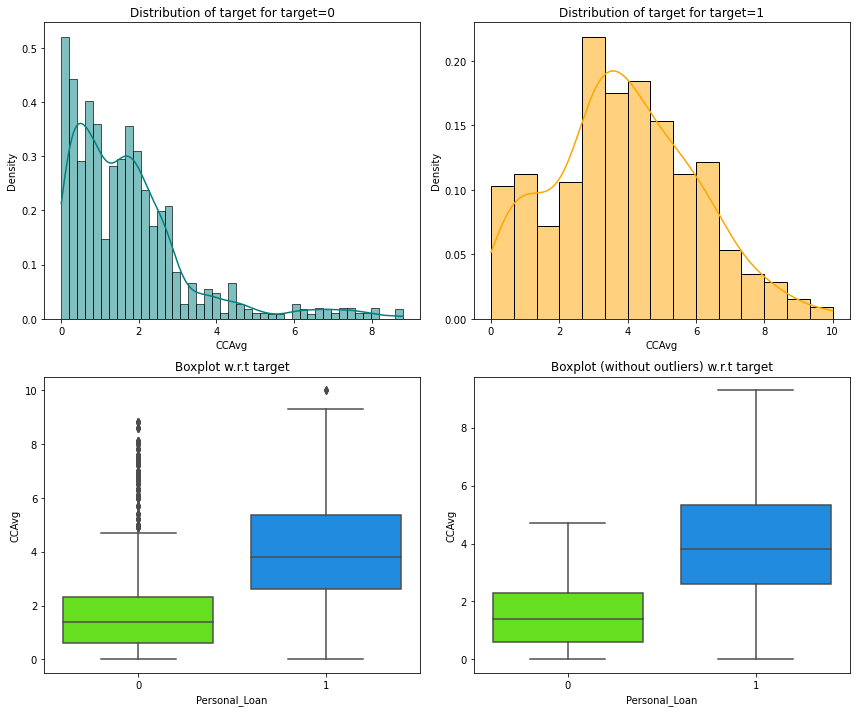

<IPython.core.display.Javascript object>

In [1236]:
distribution_plot_wrt_target(loan_df, "CCAvg", "Personal_Loan")

##### Observations:
The data shows that those who spend more money per month are more likely to accept a personal loan.

#### Education vs Personal_Loan

Personal_Loan             0    1   All
Education                             
All                    4520  480  5000
Advanced/Professional  1296  205  1501
Graduate               1221  182  1403
Undergraduate          2003   93  2096
------------------------------------------------------------------------------------------------------------------------


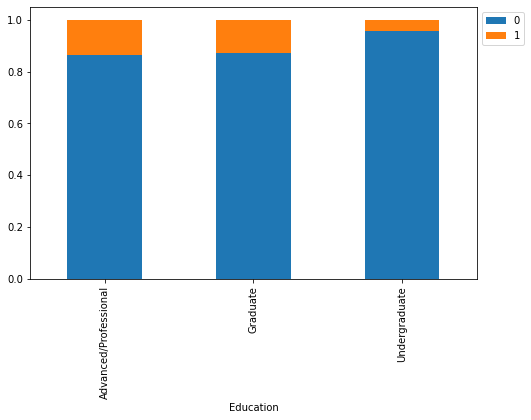

<IPython.core.display.Javascript object>

In [1237]:
stacked_barplot(loan_df, "Education", "Personal_Loan")

##### Observations:
- Fewer Undergraduate customers have accepted a personal loan offered in the last campaign, compared to customers with a Graduate or Advanced/Professional education
- There doesn't seem to be a significant difference between customers with Advanced/Professional and Graduate level education with regards to accepting the personal loan offered in the last campaign. 
- It seems customers with Advanced/Professional and Graducate level educations are more willing to accept a personal loan than those with an Undergraduate education. 

#### Mortgage vs Personal_Loan

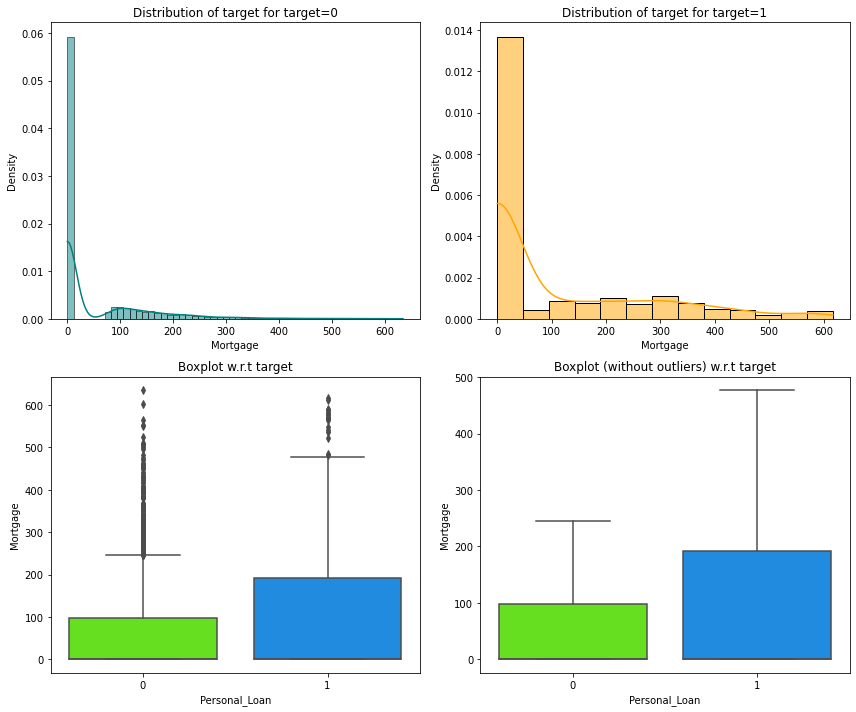

<IPython.core.display.Javascript object>

In [1238]:
distribution_plot_wrt_target(loan_df, "Mortgage", "Personal_Loan")

Due to the high number of customers not paying a mortgage, the distribution looks to be heavily skewed to the right. To get a better look, let us create a new plot that does not include the customers paying no mortgage:

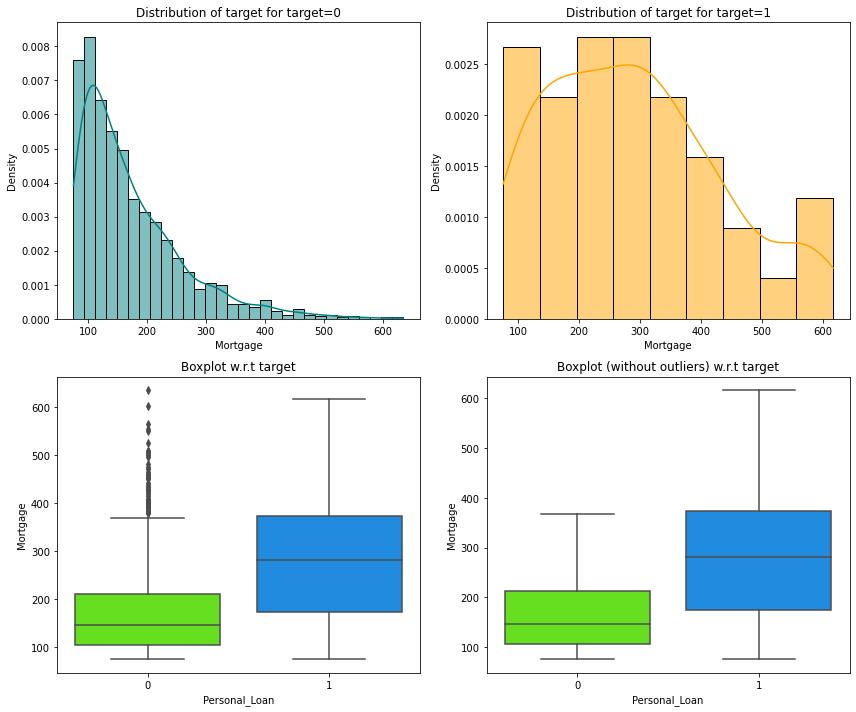

<IPython.core.display.Javascript object>

In [1239]:
distribution_plot_wrt_target(mortgage_gt_zero, "Mortgage", "Personal_Loan")

##### Observations:
- The mean value of mortgage paid by customers not accepting a personal loan is about $150k
- The mean value of mortgage paid by customers paying a personal loan is about $290k
- Based on this data, it appears that as the mortgage value increases, the more likely the customer is to accept a personal loan

#### Securities_Account vs Personal_Loan

Securities_Account     0    1   All
Personal_Loan                      
All                 4478  522  5000
0                   4058  462  4520
1                    420   60   480
------------------------------------------------------------------------------------------------------------------------


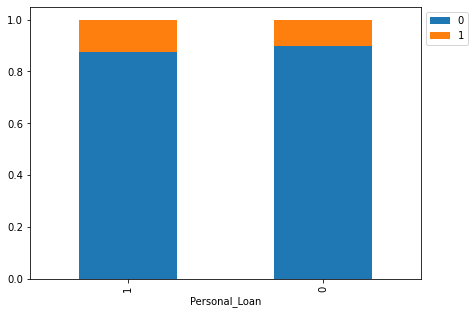

<IPython.core.display.Javascript object>

In [1240]:
stacked_barplot(loan_df, "Personal_Loan", "Securities_Account")  

##### Observations:
The data shows that those with a securities account with the bank are slightly more likely to accept a personal loan. 

#### CD_Account vs Personal_Loan

CD_Account        0    1   All
Personal_Loan                 
All            4698  302  5000
0              4358  162  4520
1               340  140   480
------------------------------------------------------------------------------------------------------------------------


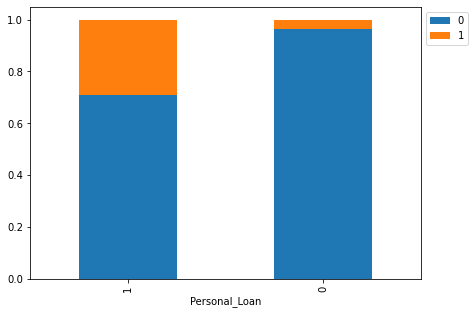

<IPython.core.display.Javascript object>

In [1241]:
stacked_barplot(loan_df, "Personal_Loan", "CD_Account")  

##### Observations:
The data shows that those customers with a CD account with the bank are much more likely to accept a personal loan.

#### Online vs Personal_Loan

Online            0     1   All
Personal_Loan                  
All            2016  2984  5000
0              1827  2693  4520
1               189   291   480
------------------------------------------------------------------------------------------------------------------------


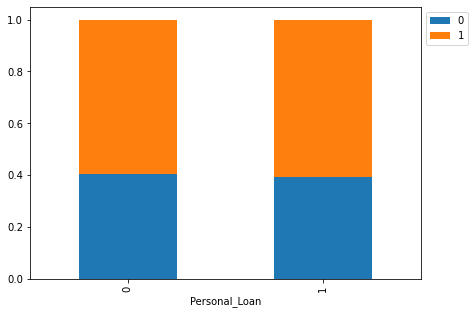

<IPython.core.display.Javascript object>

In [1242]:
stacked_barplot(loan_df, "Personal_Loan", "Online")  

##### Observations:
The data shows that customers who use internet banking facilities are about equally likely to accept a personal loan as those who do not use internet banking facilities. 

#### CreditCard vs Personal_Loan

CreditCard        0     1   All
Personal_Loan                  
All            3530  1470  5000
0              3193  1327  4520
1               337   143   480
------------------------------------------------------------------------------------------------------------------------


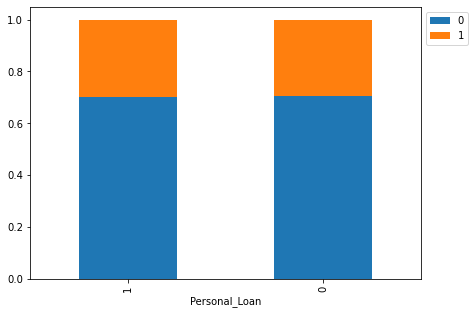

<IPython.core.display.Javascript object>

In [1243]:
stacked_barplot(loan_df, "Personal_Loan", "CreditCard")  

##### Observations:
The data shows that customers who use credit cards issues by other banks are about equally likely to accept a personal loan as those who do not use credit cards from other banks. 

#### **Questions:**
What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution? 

##### **Question 1: What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?** 

Based on our Univariate analysis of Mortgage, the mortgage distribution is skewed to the right. There are a signifiant number of customers who do not have a mortgage (mortgage or $0k) that highly influence the mean mortgage value. When not considering these customers, the minimum mortgage value is about $99k and the maximum mortgage value is about $635k. The right-skewed distribution of mortgage values among customers with mortgages suggests that the majority of customers have lower mortgage amounts, while a few customers have relatively higher mortgage amounts.This distribution pattern also suggests that there is a variation in mortgage amounts among customers, with some customers having significantly higher mortgage amounts compared to others. It could be indicative of different factors such as income levels, housing preferences, or loan eligibility criteria influencing the mortgage amounts.

##### **Question 2: How many customers have credit cards?**

In [1244]:
# Count the number of customers who use a credit card issued by any other bank
credit_card_count = loan_df['CreditCard'].value_counts()[1]
print("Number of customers with credit cards:", credit_card_count)

Number of customers with credit cards: 1470


<IPython.core.display.Javascript object>

In [1245]:
# Count the number of customers who spend more than $0 on average per month
ccavg_count = (loan_df['CCAvg'] > 0).sum()
print("Number of people with CCAvg greater than 0:", ccavg_count)


Number of people with CCAvg greater than 0: 4894


<IPython.core.display.Javascript object>

Answering "How many customers have credit cards?" can be a little tricky based on the data available to us. We could count up customers who use a credit card issues by any other bank by using CreditCard attribute, but this would not include the number of customers who have a credit card with only All Life Bank. Based on the above code, there are 1470 customers who have credit cards with other banks (excluding All Life Bank).

Looking at CCAvg and counting up the number of customers who have an average spending on credit cards per month greater than 0 might be a more accurate estimation of the number of customers who have a credit card. Based on the code above to check this, there are 4894 customers who have credit cards. 

##### **Question 3: What are the attributes that have a strong correlation with the target attribute (personal loan)?**

Based on our Bivariate analysis, the attributes that have a strong correlation with the target attribute (personal loan) are: 
- `Income`: Customers with higher income are more likely to accept a personal loan
- `Family`: Customers with family sizes 3 or 4 are more likely to accept a personal loan
- `CCAvg`: Customers with higher spending on the credit cards are more likely to accept a personal loan
- `Education`: Customers with education levels of Advanced/Professional or Graduate are more likely to accept a personal loan
- `Mortgage`: Customers with higher mortgages are more likely to accept a personal loan
- `CD_Accounts`: Customers with CD accounts are more likely to accept a personal loan

##### **Question 4: How does a customer's interest in purchasing a loan vary with their age?**

Based on our Bivariate analysis on Age vs Personal_Loan, there is not a correlation between a customer's age and their interest in a personal loan. 

##### **Question 5: How does a customer's interest in purchasing a loan vary with their education?**
Based on our Bivariate analysis on Education vs Personal_Loan, there is more interest in a personal loan for customers who have education levels of Advanced/Professional or Graduate, and less interest for customers with an education level of Undergraduate. 

Based on our Bivariate analysis on Education vs Personal_Loan, 

### Data Preparation for Modeling

#### Separate independent and dependent variable:

In [1246]:
# Separate independent and dependent variable
X = loan_df.drop(["Personal_Loan", "Experience"], axis=1)
Y = loan_df["Personal_Loan"]

<IPython.core.display.Javascript object>

#### Creating dummy variables and Splitting the data:

In [1247]:

# Apply dummies on ZIPCode and Education
X = pd.get_dummies(X, columns=["ZIPCode", "Education"], drop_first=True)  

# Split data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

<IPython.core.display.Javascript object>

#### Check the shape and percentages of Training and Test sets:

In [1248]:
print("Shape of Training set : ", X_train.shape)     
print("Shape of Test set : ", X_test.shape)          
print("Percentage of classes in Training set:")
print(y_train.value_counts(normalize=True))              
print("Percentage of classes in Test set:")
print(y_test.value_counts(normalize=True))           

Shape of Training set :  (3500, 17)
Shape of Test set :  (1500, 17)
Percentage of classes in Training set:
0    0.905429
1    0.094571
Name: Personal_Loan, dtype: float64
Percentage of classes in Test set:
0    0.900667
1    0.099333
Name: Personal_Loan, dtype: float64


<IPython.core.display.Javascript object>

## Model Building

### Model Evaluation Criterion

**Model can make wrong predictions as:**

1. Predicting a customer will take the personal loan but in reality the customer will not take the personal loan - Loss of resources
2. Predicting a customer will not take the personal loan but in reality the customer was going to take the personal loan - Loss of opportunity

**Which case is more important?**
* Losing a potential customer by predicting that the customer will not be taking the personal loan but in reality the customer was going to take the personal loan - Loss of opportunity

**How to reduce this loss i.e need to reduce False Negatives?**

* Bank would want `Recall` to be maximized, greater the Recall higher the chances of minimizing false negatives. Hence, the focus should be on increasing Recall or minimizing the false negatives.

### Model Building: Logistic Regression

First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The model_performance_classification_sklearn_with_threshold function will be used to check the model performance of models. 
* The confusion_matrix_sklearn_with_threshold function will be used to plot confusion matrix.

In [1249]:
# Defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn_with_threshold(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [1250]:
# Defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

#### Building the Logistic Regression Model

In [1251]:
lg = LogisticRegression(random_state=1)
model = lg.fit(X_train, y_train)

<IPython.core.display.Javascript object>

#### Checking model performance on training set:

Training performance:


,Accuracy,Recall,Precision,F1
0,0.958286,0.655589,0.871486,0.748276


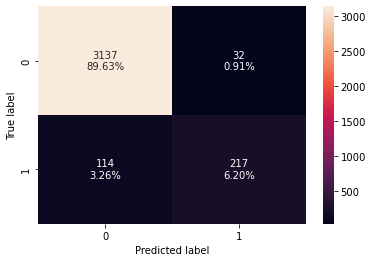

<IPython.core.display.Javascript object>

In [1252]:
# create confusion matrix
confusion_matrix_sklearn_with_threshold(lg, X_train, y_train)

# Model Performance on train 
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(lg, X_train, y_train)

print("Training performance:")
log_reg_model_train_perf

#### Checking model performance on test set:

Test performance:


,Accuracy,Recall,Precision,F1
0,0.954667,0.637584,0.87156,0.736434


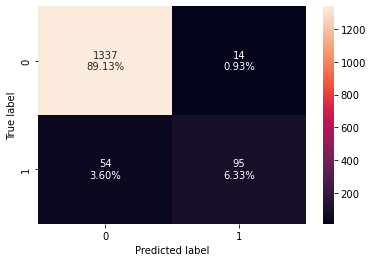

<IPython.core.display.Javascript object>

In [1253]:
confusion_matrix_sklearn_with_threshold(model, X_test, y_test)
log_reg_model_test_perf = model_performance_classification_sklearn_with_threshold(model, X_test, y_test)

print("Test performance:")
log_reg_model_test_perf

### Model Performance Improvement: Logistic Regression

#### ROC-AUC

* The area under the ROC curve (AUC) is a measure of how good a model is - The higher the AUC, the better the model is, at distinguishing between classes.

**ROC-AUC on training set**

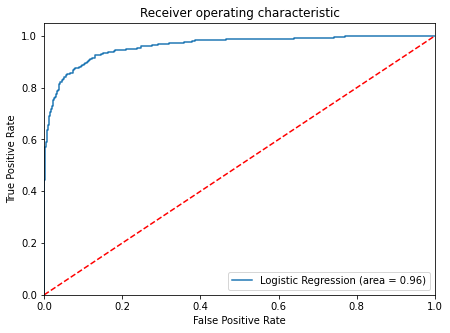

<IPython.core.display.Javascript object>

In [1254]:
# Find the roc auc score for training data
logit_roc_auc_train = roc_auc_score(
    y_train, lg.predict_proba(X_train)[:, 1]
)  # The indexing represents predicted probabilities for class 1
# Find fpr, tpr and threshold values
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])
plt.figure(figsize=(7, 5))
# Plot roc curve
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

**Optimal threshold using AUC-ROC curve**

In [1255]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
# roc_curve returns the fpr, tpr and threshold values which takes the original data and predicted probabilities for the class 1.
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])

optimal_idx = np.argmax(
    tpr - fpr
)  # Finds the index that contains the max difference between tpr and fpr
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.13986406663744005


<IPython.core.display.Javascript object>

**Checking model performance on the training data**

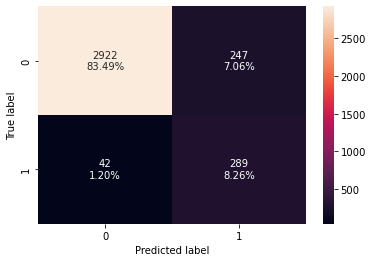

<IPython.core.display.Javascript object>

In [1256]:
# Creating confusion matrix
confusion_matrix_sklearn_with_threshold(lg, X_train, y_train, threshold=optimal_threshold_auc_roc)


In [1257]:
# Checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.917429,0.873112,0.539179,0.666667


<IPython.core.display.Javascript object>

**Use the above threshold and apply on test data**

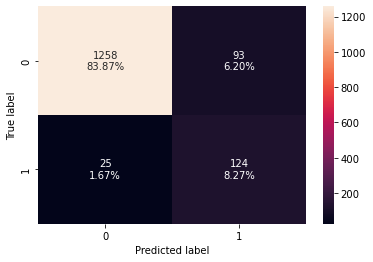

<IPython.core.display.Javascript object>

In [1258]:
confusion_matrix_sklearn_with_threshold(model, X_test, y_test, threshold=optimal_threshold_auc_roc)

In [1259]:
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(model, X_test, y_test, threshold=optimal_threshold_auc_roc)
print("Test performance:")
print(log_reg_model_test_perf_threshold_auc_roc)

Test performance:
   Accuracy    Recall  Precision        F1
0  0.921333  0.832215   0.571429  0.677596


<IPython.core.display.Javascript object>

**Precision-Recall Curve**

Let's use Precision-Recall curve and see if we can find a better threshold.

The Precision-Recall curve shows the tradeoff between Precision and Recall for different thresholds. It can be used to select optimal threshold as required to improve the model improvement. 

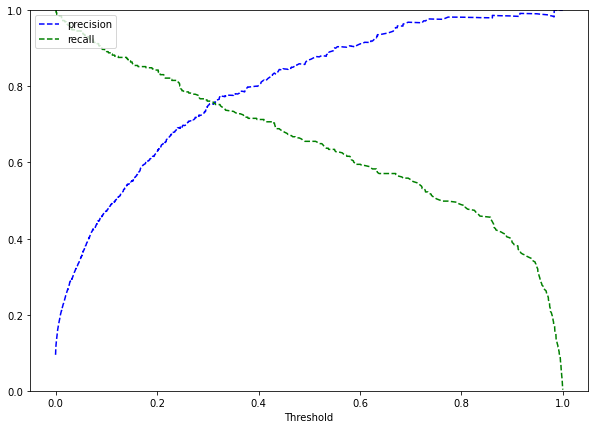

Optimal Threshold: 0.4313549782502168


<IPython.core.display.Javascript object>

In [1260]:
# Find the predicted probabilities for class 1
y_scores = lg.predict_proba(X_train)[:, 1]

# Find precision, recall, and threshold values
prec, rec, tre = precision_recall_curve(y_train, y_scores)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

# Plot precision-recall curve
plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

# Find the optimal threshold
optimal_threshold_curve = tre[np.argmax(2 * prec * rec / (prec + rec))]

print("Optimal Threshold:", optimal_threshold_curve)

**Check the model performance on training data**

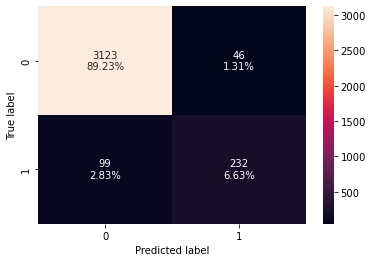

<IPython.core.display.Javascript object>

In [1261]:
# Creating confusion matrix
confusion_matrix_sklearn_with_threshold(lg, X_train, y_train, threshold=optimal_threshold_curve)

In [1262]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.958571,0.700906,0.834532,0.761905


<IPython.core.display.Javascript object>

**Check the model performance on test data**

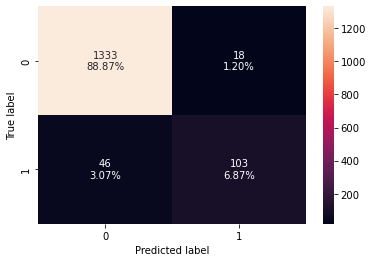

<IPython.core.display.Javascript object>

In [1263]:
# Creating confusion matrix
confusion_matrix_sklearn_with_threshold(lg, X_test, y_test, threshold=optimal_threshold_curve)

In [1264]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)
print("Test data performance:")
log_reg_model_test_perf_threshold_curve

Test data performance:


,Accuracy,Recall,Precision,F1
0,0.957333,0.691275,0.85124,0.762963


<IPython.core.display.Javascript object>

### Model Performance Comparison: Logistic Regression

In [1265]:
# Training performance comparison
models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression sklearn Default Threshold",
    "Logistic Regression-2 ROC-AUC Curve Threshold",
    "Logistic Regression-3 Precision-Recall Curve Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression sklearn Default Threshold,Logistic Regression-2 ROC-AUC Curve Threshold,Logistic Regression-3 Precision-Recall Curve Threshold
Accuracy,0.958286,0.917429,0.958571
Recall,0.655589,0.873112,0.700906
Precision,0.871486,0.539179,0.834532
F1,0.748276,0.666667,0.761905


<IPython.core.display.Javascript object>

In [1266]:
# Testing performance comparison
models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression sklearn Default Threshold",
    "Logistic Regression-2 ROC-AUC Curve Threshold",
    "Logistic Regression-3 Precision-Recall Curve Threshold",
]

print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Logistic Regression sklearn Default Threshold,Logistic Regression-2 ROC-AUC Curve Threshold,Logistic Regression-3 Precision-Recall Curve Threshold
Accuracy,0.954667,0.921333,0.957333
Recall,0.637584,0.832215,0.691275
Precision,0.871560,0.571429,0.851240
F1,0.736434,0.677596,0.762963


<IPython.core.display.Javascript object>

##### Observations:
Using Precision-Recall Curve to find the threshold gave different results than when we used the AUC-ROC Curve.

-  Accuracy increased from about 0.92 to about 0.96 by using the Precision-Recall Curve rather than the AUC-ROC Curve to find the threshold. 
- Recall decreased from about 0.87 and about 0.83 for testing and training, respectively, to about about 0.70 and about 0.69 for testing and training, respectively, by using the threshold from Precision-Recall Curve instead of from the AUC-ROC Curve. 
- Precision saw a significant increased in both training and testing data by using the threshold for Precision-Recall Curve vs AUC-ROC Curve (up to about 0.83-0.85 from 0.54-0.57).
- F1 score went up to about 0.76 from about 0.67 by using the Precision-Recall Curve threshold rather than the AUC-ROC Curve. 

Because we established earlier that the bank would want `Recall` to be maximized, because the greater the Recall, the higher the chances of minimizing false negatives, hence the focus should be on increasing Recall (minimizing the false negatives).

Because of this, it would be better in this situation to use the threshold given by Precision-Recall Curve. 

### Model Building: Decision Tree

First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.

* The model_performance_classification_sklearn function will be used to check the model performance of models. 
* The confusion_matrix_sklearnfunction will be used to plot confusion matrix.

In [1267]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [1268]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

#### Build Decision Tree Model

In [1269]:
# Initialize the Decision Tree Classifier
model = DecisionTreeClassifier(criterion="gini", random_state=1)

# Fit the decision tree on the train data
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

<IPython.core.display.Javascript object>

#### Checking model performance on training data

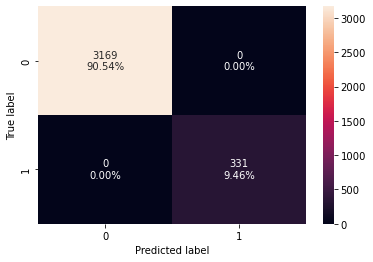

<IPython.core.display.Javascript object>

In [1270]:
confusion_matrix_sklearn(model, X_train, y_train) 

In [1271]:
decision_tree_perf_train = model_performance_classification_sklearn(model, X_train, y_train)
decision_tree_perf_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


<IPython.core.display.Javascript object>

##### Observation:
Because we are getting perfect scores of 1.0 for accuracy, recall, precision, and F1 on the training data, it may indicate that the decision tree model has overfit the training data. Overfitting occurs when the model learns the training data too well and fails to generalize well to unseen data.

To confirm if overfitting is occurring, it's important to evaluate the model's performance on the test data as well.

#### Visualizing the Decision Tree

In [1272]:
feature_names = list(X_train.columns)
print(feature_names)

['Age', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'ZIPCode_91', 'ZIPCode_92', 'ZIPCode_93', 'ZIPCode_94', 'ZIPCode_95', 'ZIPCode_96', 'Education_Graduate', 'Education_Undergraduate']


<IPython.core.display.Javascript object>

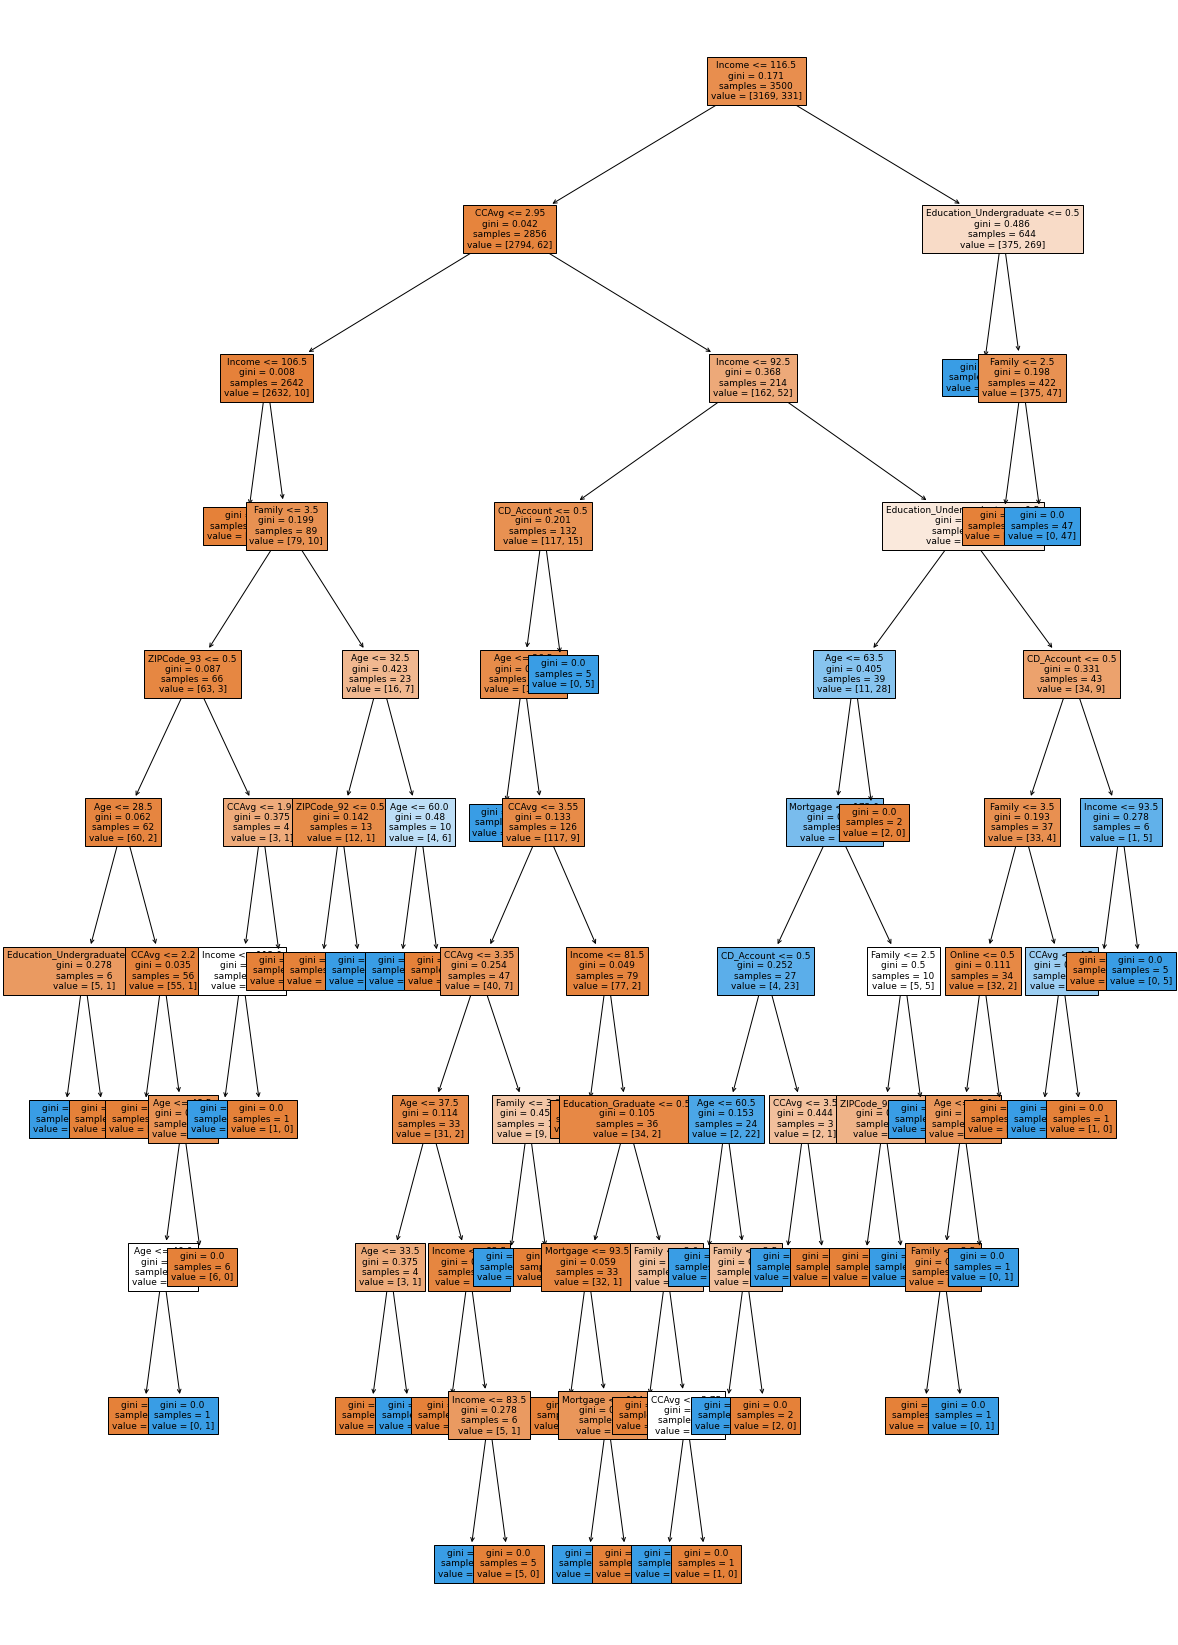

<IPython.core.display.Javascript object>

In [1273]:
plt.figure(figsize=(20, 30))
out = tree.plot_tree(
    model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# Below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [1274]:
# Text report showing the rules of a decision tree
print(tree.export_text(model, feature_names=feature_names, show_weights=True))

|--- Income <= 116.50
|   |--- CCAvg <= 2.95
|   |   |--- Income <= 106.50
|   |   |   |--- weights: [2553.00, 0.00] class: 0
|   |   |--- Income >  106.50
|   |   |   |--- Family <= 3.50
|   |   |   |   |--- ZIPCode_93 <= 0.50
|   |   |   |   |   |--- Age <= 28.50
|   |   |   |   |   |   |--- Education_Undergraduate <= 0.50
|   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |   |--- Education_Undergraduate >  0.50
|   |   |   |   |   |   |   |--- weights: [5.00, 0.00] class: 0
|   |   |   |   |   |--- Age >  28.50
|   |   |   |   |   |   |--- CCAvg <= 2.20
|   |   |   |   |   |   |   |--- weights: [48.00, 0.00] class: 0
|   |   |   |   |   |   |--- CCAvg >  2.20
|   |   |   |   |   |   |   |--- Age <= 48.50
|   |   |   |   |   |   |   |   |--- Age <= 40.00
|   |   |   |   |   |   |   |   |   |--- weights: [1.00, 0.00] class: 0
|   |   |   |   |   |   |   |   |--- Age >  40.00
|   |   |   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |

<IPython.core.display.Javascript object>

In [1275]:
print(
    pd.DataFrame(
        model.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

                              Imp
Education_Undergraduate  0.403732
Income                   0.305688
Family                   0.166733
CCAvg                    0.049492
Age                      0.032549
CD_Account               0.025711
Mortgage                 0.006250
ZIPCode_94               0.004767
ZIPCode_92               0.003080
Education_Graduate       0.000843
ZIPCode_93               0.000594
Online                   0.000561
Securities_Account       0.000000
ZIPCode_91               0.000000
ZIPCode_95               0.000000
ZIPCode_96               0.000000
CreditCard               0.000000


<IPython.core.display.Javascript object>

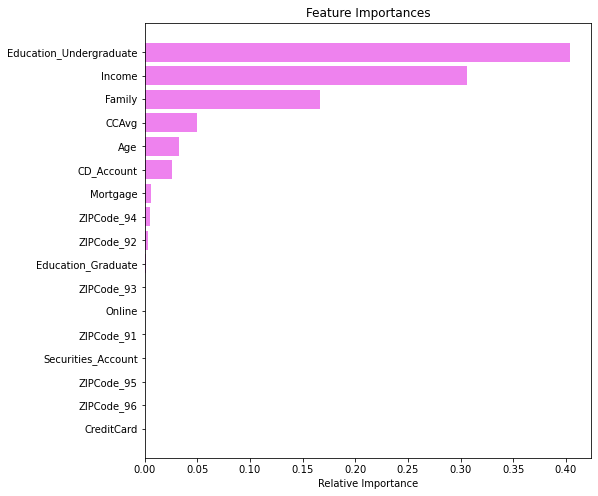

<IPython.core.display.Javascript object>

In [1276]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

#### Checking model performance on test data

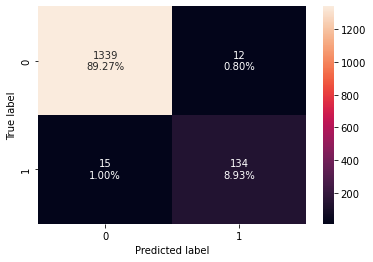

<IPython.core.display.Javascript object>

In [1277]:
confusion_matrix_sklearn(model, X_test, y_test)  

In [1278]:
decision_tree_perf_test = model_performance_classification_sklearn(model, X_test, y_test)
decision_tree_perf_test

,Accuracy,Recall,Precision,F1
0,0.982,0.899329,0.917808,0.908475


<IPython.core.display.Javascript object>

##### Observations:
Based on the performance of the decision tree model, it can be observed that the model achieves high accuracy (98.2%) on the test data. This indicates that the model is able to accurately predict whether a customer will accept a personal loan in the majority of cases.

Furthermore, the model demonstrates strong recall (89.9%), precision (91.8%), and F1 score (90.8%). These metrics indicate that the model performs well in correctly identifying customers who are likely to accept a personal loan (high recall) while also minimizing false positives (high precision). This suggests that the model has a good ability to distinguish between customers who are likely to accept a personal loan and those who are not.

Overall, the decision tree model shows promising performance and can be considered as an effective tool for predicting customer acceptance of personal loans.

### Model Performance Improvement: Decision Tree

#### Pre-Pruning

In [1279]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(6, 15),
    "min_samples_leaf": [1, 2, 5, 7, 10],
    "max_leaf_nodes": [2, 3, 5, 10],
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the model on the training data
estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10, random_state=1)

<IPython.core.display.Javascript object>

**Checking performance on training data**

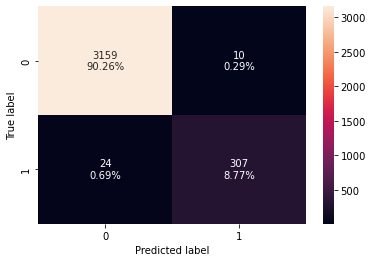

<IPython.core.display.Javascript object>

In [1280]:
confusion_matrix_sklearn(estimator, X_train, y_train)

In [1281]:
decision_tree_tune_perf_train = model_performance_classification_sklearn(estimator, X_train, y_train)
decision_tree_tune_perf_train

,Accuracy,Recall,Precision,F1
0,0.990286,0.927492,0.968454,0.947531


<IPython.core.display.Javascript object>

**Visualizing the Decision Tree**

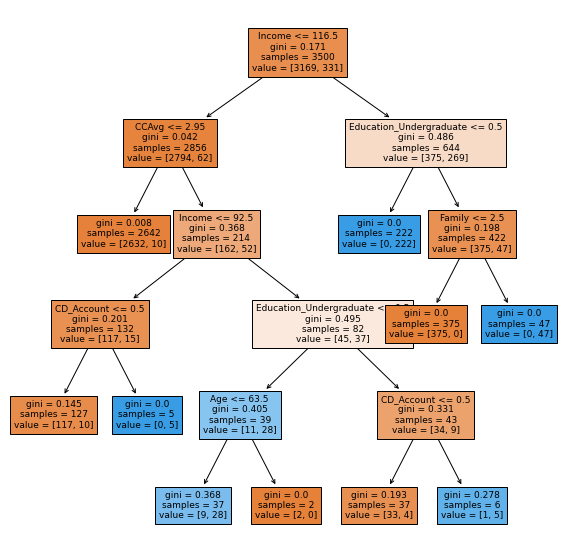

<IPython.core.display.Javascript object>

In [1282]:
plt.figure(figsize=(10, 10))
out = tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [1283]:
# Text report showing the rules of a decision tree
print(tree.export_text(estimator, feature_names=feature_names, show_weights=True))

|--- Income <= 116.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [2632.00, 10.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 92.50
|   |   |   |--- CD_Account <= 0.50
|   |   |   |   |--- weights: [117.00, 10.00] class: 0
|   |   |   |--- CD_Account >  0.50
|   |   |   |   |--- weights: [0.00, 5.00] class: 1
|   |   |--- Income >  92.50
|   |   |   |--- Education_Undergraduate <= 0.50
|   |   |   |   |--- Age <= 63.50
|   |   |   |   |   |--- weights: [9.00, 28.00] class: 1
|   |   |   |   |--- Age >  63.50
|   |   |   |   |   |--- weights: [2.00, 0.00] class: 0
|   |   |   |--- Education_Undergraduate >  0.50
|   |   |   |   |--- CD_Account <= 0.50
|   |   |   |   |   |--- weights: [33.00, 4.00] class: 0
|   |   |   |   |--- CD_Account >  0.50
|   |   |   |   |   |--- weights: [1.00, 5.00] class: 1
|--- Income >  116.50
|   |--- Education_Undergraduate <= 0.50
|   |   |--- weights: [0.00, 222.00] class: 1
|   |--- Education_Undergraduate >  0.50
|   |   |--- Family <= 2.

<IPython.core.display.Javascript object>

In [1284]:
print(
    pd.DataFrame(
        model.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

                              Imp
Education_Undergraduate  0.403732
Income                   0.305688
Family                   0.166733
CCAvg                    0.049492
Age                      0.032549
CD_Account               0.025711
Mortgage                 0.006250
ZIPCode_94               0.004767
ZIPCode_92               0.003080
Education_Graduate       0.000843
ZIPCode_93               0.000594
Online                   0.000561
Securities_Account       0.000000
ZIPCode_91               0.000000
ZIPCode_95               0.000000
ZIPCode_96               0.000000
CreditCard               0.000000


<IPython.core.display.Javascript object>

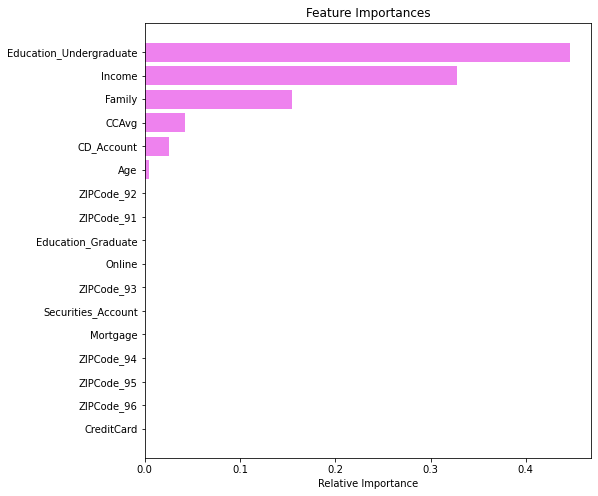

<IPython.core.display.Javascript object>

In [1285]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

**Checking performance on test data**

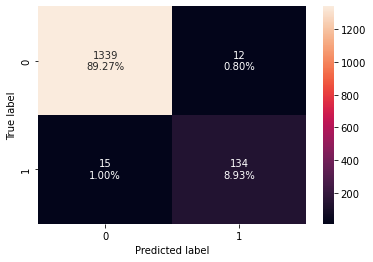

<IPython.core.display.Javascript object>

In [1286]:
confusion_matrix_sklearn(model, X_test, y_test) 

In [1287]:
decision_tree_tune_perf_test = model_performance_classification_sklearn(estimator, X_test, y_test)
print("Test performance:")
decision_tree_tune_perf_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.98,0.865772,0.928058,0.895833


<IPython.core.display.Javascript object>

#### Cost-Complexity Pruning

In [1288]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

<IPython.core.display.Javascript object>

In [1289]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.000000,0.000000
1,0.000186,0.001114
2,0.000187,0.001675
3,0.000214,0.002104
4,0.000216,0.002750
5,0.000268,0.003824
6,0.000359,0.004900
7,0.000381,0.005280
8,0.000381,0.005661
9,0.000381,0.006042


<IPython.core.display.Javascript object>

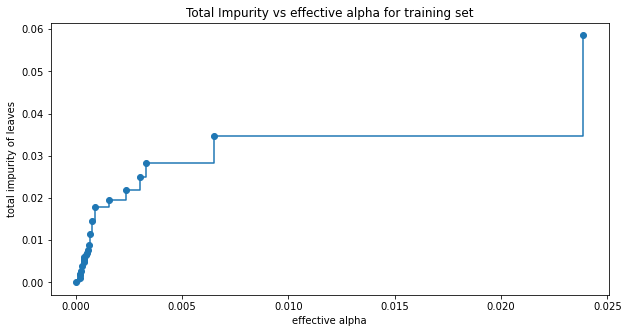

<IPython.core.display.Javascript object>

In [1290]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

Next, we train a decision tree using effective alphas. The last value
in ``ccp_alphas`` is the alpha value that prunes the whole tree,
leaving the tree, ``clfs[-1]``, with one node.

In [1291]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.056364969335601575


<IPython.core.display.Javascript object>

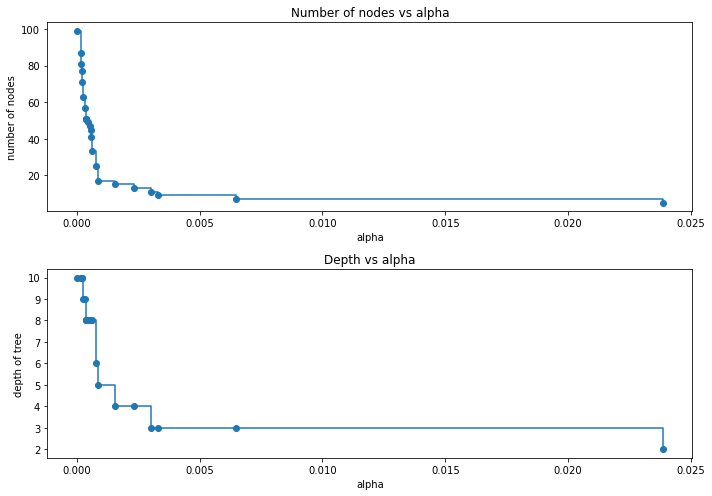

<IPython.core.display.Javascript object>

In [1292]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

**Recall vs alpha for training and testing sets**

In [1293]:
recall_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = recall_score(y_train, pred_train)
    recall_train.append(values_train)

recall_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    values_test = recall_score(y_test, pred_test)
    recall_test.append(values_test)

<IPython.core.display.Javascript object>

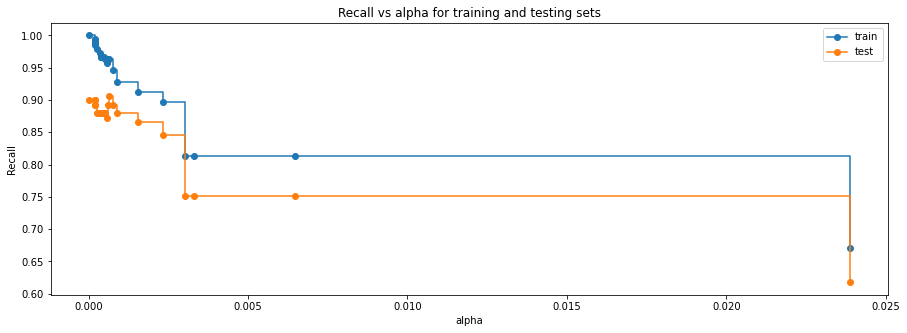

<IPython.core.display.Javascript object>

In [1294]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [1295]:
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.0006414326414326415, random_state=1)


<IPython.core.display.Javascript object>

**Checking Model Performance on training set**

In [1296]:
decision_tree_postpruned_perf_train = model_performance_classification_sklearn(
    best_model, X_train, y_train
)
decision_tree_postpruned_perf_train

,Accuracy,Recall,Precision,F1
0,0.993143,0.963746,0.963746,0.963746


<IPython.core.display.Javascript object>

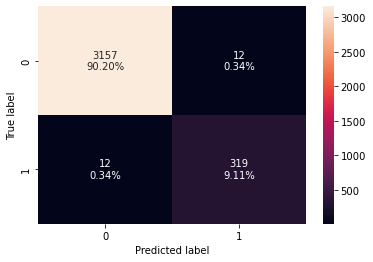

<IPython.core.display.Javascript object>

In [1297]:
confusion_matrix_sklearn(best_model, X_train, y_train)

**Checking Model Performance on test set**

In [1298]:
decision_tree_postpruned_perf_test = model_performance_classification_sklearn(
    best_model, X_test, y_test
)
decision_tree_postpruned_perf_test

,Accuracy,Recall,Precision,F1
0,0.984,0.90604,0.931034,0.918367


<IPython.core.display.Javascript object>

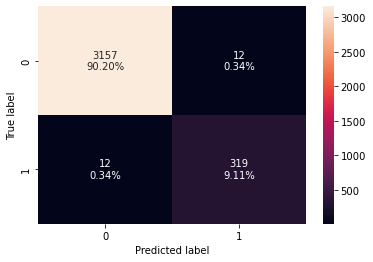

<IPython.core.display.Javascript object>

In [1299]:
confusion_matrix_sklearn(best_model, X_train, y_train)

### Visualizing the Decision Tree

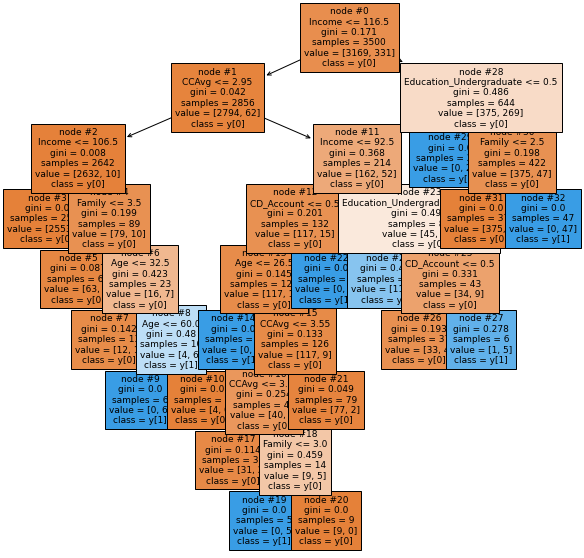

<IPython.core.display.Javascript object>

In [1300]:
plt.figure(figsize=(10, 10))

out = tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=True,
    class_names=True,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()
plt.show()

In [1301]:
# Text report showing the rules of a decision tree -
print(tree.export_text(best_model, feature_names=feature_names, show_weights=True))

|--- Income <= 116.50
|   |--- CCAvg <= 2.95
|   |   |--- Income <= 106.50
|   |   |   |--- weights: [2553.00, 0.00] class: 0
|   |   |--- Income >  106.50
|   |   |   |--- Family <= 3.50
|   |   |   |   |--- weights: [63.00, 3.00] class: 0
|   |   |   |--- Family >  3.50
|   |   |   |   |--- Age <= 32.50
|   |   |   |   |   |--- weights: [12.00, 1.00] class: 0
|   |   |   |   |--- Age >  32.50
|   |   |   |   |   |--- Age <= 60.00
|   |   |   |   |   |   |--- weights: [0.00, 6.00] class: 1
|   |   |   |   |   |--- Age >  60.00
|   |   |   |   |   |   |--- weights: [4.00, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 92.50
|   |   |   |--- CD_Account <= 0.50
|   |   |   |   |--- Age <= 26.50
|   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |--- Age >  26.50
|   |   |   |   |   |--- CCAvg <= 3.55
|   |   |   |   |   |   |--- CCAvg <= 3.35
|   |   |   |   |   |   |   |--- weights: [31.00, 2.00] class: 0
|   |   |   |   |   |   |--- CCAvg >  3.35
|   

<IPython.core.display.Javascript object>

In [1302]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        best_model.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

                              Imp
Education_Undergraduate  0.429489
Income                   0.319013
Family                   0.164852
CCAvg                    0.045185
CD_Account               0.024298
Age                      0.017163
Securities_Account       0.000000
Online                   0.000000
Mortgage                 0.000000
ZIPCode_91               0.000000
ZIPCode_92               0.000000
ZIPCode_93               0.000000
ZIPCode_94               0.000000
ZIPCode_95               0.000000
ZIPCode_96               0.000000
Education_Graduate       0.000000
CreditCard               0.000000


<IPython.core.display.Javascript object>

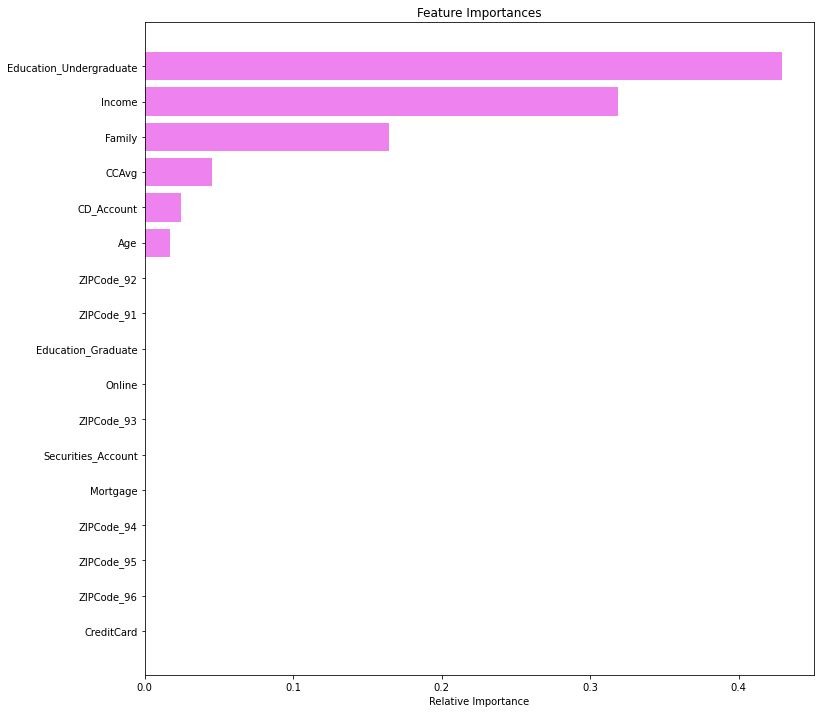

<IPython.core.display.Javascript object>

In [1303]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Model Performance Comparison: Decision Tree

In [1304]:
# Training performance comparison
models_train_comp_df = pd.concat(
    [
        decision_tree_perf_train.T, 
        decision_tree_tune_perf_train.T,
        decision_tree_postpruned_perf_train.T
    ], 
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree sklearn", 
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree sklearn,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,1.0,0.990286,0.993143
Recall,1.0,0.927492,0.963746
Precision,1.0,0.968454,0.963746
F1,1.0,0.947531,0.963746


<IPython.core.display.Javascript object>

In [1305]:
# Test performance comparison
models_test_comp_df = pd.concat(
    [
        decision_tree_perf_test.T,
        decision_tree_tune_perf_test.T,
        decision_tree_postpruned_perf_test.T
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree sklearn",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Test performance comparison:")
models_test_comp_df


Test performance comparison:


,Decision Tree sklearn,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,0.982000,0.980000,0.984000
Recall,0.899329,0.865772,0.906040
Precision,0.917808,0.928058,0.931034
F1,0.908475,0.895833,0.918367


<IPython.core.display.Javascript object>

## Model Comparison and Final Model Selection

In [1306]:
# Test performance comparison
models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
        decision_tree_perf_test.T,
        decision_tree_tune_perf_test.T,
        decision_tree_postpruned_perf_test.T
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression sklearn Default Threshold",
    "Logistic Regression-2 ROC-AUC Curve Threshold",
    "Logistic Regression-3 Precision-Recall Curve Threshold",
    "Decision Tree sklearn",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Test performance comparison:")
models_test_comp_df


Test performance comparison:


,Logistic Regression sklearn Default Threshold,Logistic Regression-2 ROC-AUC Curve Threshold,Logistic Regression-3 Precision-Recall Curve Threshold,Decision Tree sklearn,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,0.954667,0.921333,0.957333,0.982000,0.980000,0.984000
Recall,0.637584,0.832215,0.691275,0.899329,0.865772,0.906040
Precision,0.871560,0.571429,0.851240,0.917808,0.928058,0.931034
F1,0.736434,0.677596,0.762963,0.908475,0.895833,0.918367


<IPython.core.display.Javascript object>

##### Observations:
- Logistic Regression models have lower recall values compared to Decision Tree models.
- Decision Tree models have higher recall values, indicating a better ability to correctly identify positive instances (customers who accept the personal loan).
- Among the Decision Tree models, the "Decision Tree (Post-Pruning)" model has the highest recall value of 0.906040.
- The "Decision Tree (Post-Pruning)" model also has high precision and F1 scores, indicating a good balance between correctly identified positive instances and minimizing false positives.

When prioritizing recall, we aim to maximize the identification of positive instances (customers who accept the personal loan) even if it means having a higher number of false positives. In this scenario, the "Decision Tree (Post-Pruning)" model performs the best. It achieves a high recall value of 0.906040, indicating that it successfully identifies a significant proportion of customers who are likely to accept the personal loan. This model strikes a good balance between correctly identifying positive instances and avoiding false negatives.

Additionally, the "Decision Tree (Post-Pruning)" model demonstrates high precision and F1 scores, suggesting that it also maintains a reasonable level of accuracy in correctly classifying positive instances while minimizing false positives. This indicates its effectiveness in capturing the target segment of customers.

Therefore, considering the prioritization of recall, the "Decision Tree (Post-Pruning)" model would be the best choice among the listed models for identifying potential customers who are more likely to accept the personal loan offer.

## Actionable Insights and Business Recommendations


*What recommedations would you suggest to the bank?*

- Focus on the "Decision Tree (Post-Pruning)" model: The "Decision Tree (Post-Pruning)" model demonstrates the highest recall value and performs well in identifying customers who are likely to accept the personal loan. Therefore, the bank should prioritize using this model for targeting potential customers.

- Target customers with those more important features identified earlier, specifically: higher income, education levels of Advanced/Professional and Graduate, customers with higher monthly spending on their credit cards, family size greater than 2. 

- Customize marketing campaigns: Tailor marketing campaigns specifically to the identified target segment based on the model predictions. Craft personalized messages highlighting the benefits and features of personal loans that are likely to resonate with these customers.

- Offer personalized incentives: Provide personalized incentives or offers to customers who are predicted to have a higher likelihood of accepting the personal loan. This could include preferential interest rates, rewards, or exclusive benefits to encourage them to consider the loan offer.

- Enhance customer engagement: Utilize the bank's online platforms and internet banking facilities to engage with customers more effectively. Leverage the insight that a significant proportion of customers use online banking services, as indicated by the dataset, to deliver targeted marketing messages and facilitate a seamless loan application process.

- Monitor and evaluate performance: Continuously monitor the performance of the marketing campaigns and the accuracy of the "Decision Tree (Post-Pruning)" model. Regularly analyze the results, assess the conversion rates, and make adjustments to improve the targeting and messaging strategies accordingly.

- Conduct customer surveys and feedback: Gather feedback from customers who have accepted personal loans to understand their motivations and preferences. Use this information to further refine marketing strategies and offer customized loan products that meet their specific needs.

By implementing these recommendations, All Life Bank can improve its loan conversion rates, increase customer engagement, and drive business growth in the personal loan segment.

___